In [1]:
import torch
from google.colab import drive
import os # Added import for os, as it's used in subsequent cells

# Montar Google Drive
drive.mount('/content/drive')

# Determina si hay una GPU disponible y usa CUDA si es así.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando el dispositivo: {device}')

Mounted at /content/drive
Usando el dispositivo: cuda


In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

dataset_path = "/content/drive/MyDrive/DATASET_ORGANICO_INORGANICO_QUISPE_SUCULLANI_JOSE_DAVID/Dataset-QuispeSucullaniJoseDavid"
# Listar las subcarpetas (clases)
clases = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Clases encontradas:", clases)

Clases encontradas: ['Anillos-Min', 'Bolsas-Refrescos-Min', 'Hojas-Brocoli-Min', 'Monedas_Min', 'CablesDeRed-Min']


Clases encontradas: ['Anillos-Min', 'Bolsas-Refrescos-Min', 'Hojas-Brocoli-Min', 'Monedas_Min', 'CablesDeRed-Min']


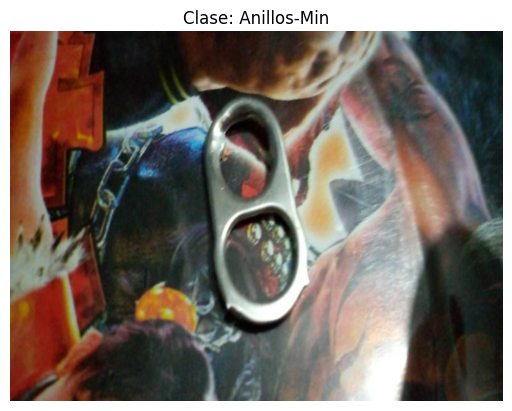

In [3]:
# Listar clases
clases = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Clases encontradas:", clases)

# Mostrar una imagen de cada clase
for clase in clases:
    # Buscar subcarpetas dentro de la clase
    subcarpetas = [d for d in os.listdir(os.path.join(dataset_path, clase))
                   if os.path.isdir(os.path.join(dataset_path, clase, d))]

    # Tomar la primera subcarpeta (si hay más de una)
    subcarpeta = subcarpetas[0] if subcarpetas else ''

    # Listar imágenes dentro de la subcarpeta
    imagenes = [f for f in os.listdir(os.path.join(dataset_path, clase, subcarpeta))
                if f.endswith(('.jpg', '.png', '.jpeg'))]

    if not imagenes:
        continue  # Saltar si no hay imágenes

    # Seleccionar imagen aleatoria
    imagen_aleatoria = random.choice(imagenes)

    # Ruta completa
    imagen_path = os.path.join(dataset_path, clase, subcarpeta, imagen_aleatoria)

    # Cargar y mostrar
    img = mpimg.imread(imagen_path)
    plt.imshow(img)
    plt.title(f"Clase: {clase}")
    plt.axis('off')
    plt.show()

Clases encontradas: ['Anillos-Min', 'Bolsas-Refrescos-Min', 'Hojas-Brocoli-Min', 'Monedas_Min', 'CablesDeRed-Min']
Anillos-Min: 5110 imágenes
Bolsas-Refrescos-Min: 0 imágenes
Hojas-Brocoli-Min: 0 imágenes
Monedas_Min: 0 imágenes
CablesDeRed-Min: 0 imágenes


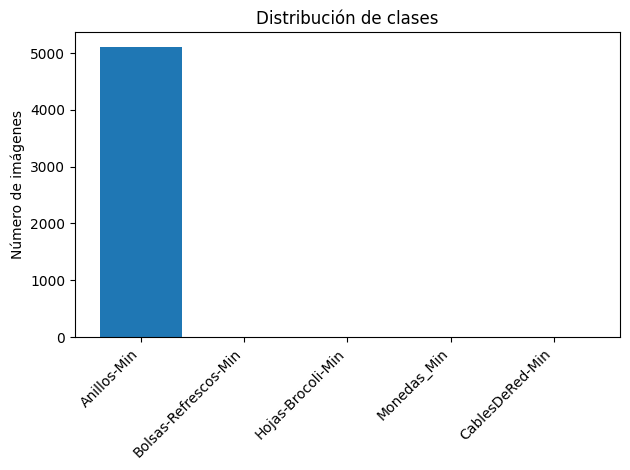

In [5]:
import os
import matplotlib.pyplot as plt

# Get the actual class names from the dataset directory
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Clases encontradas:", classes)


# Contar imágenes por clase (solo JPG)
counts = []
for c in classes:
    # Check for subdirectories within each class folder
    subfolders = [d for d in os.listdir(os.path.join(dataset_path, c))
                  if os.path.isdir(os.path.join(dataset_path, c, d))]

    num_imgs = 0
    if subfolders:
        # If there are subfolders, count images in the first subfolder
        class_folder = os.path.join(dataset_path, c, subfolders[0])
        if os.path.exists(class_folder): # Check if the subfolder exists
            num_imgs = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]) # Also include .png and .jpeg
    else:
        # If no subfolders, count images directly in the class folder
        class_folder = os.path.join(dataset_path, c)
        if os.path.exists(class_folder): # Check if the class folder exists
             num_imgs = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]) # Also include .png and .jpeg

    counts.append(num_imgs)
    print(f"{c}: {num_imgs} imágenes")

# Graficar
plt.bar(classes, counts)
plt.title("Distribución de clases")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [12]:
from PIL import Image
import torchvision.transforms as transforms # Import the transforms module

class PadToSquare:
    def __init__(self, fill=0):
        self.fill = fill

    def __call__(self, img: Image.Image):
        w, h = img.size
        max_side = max(w, h)
        pad_left = (max_side - w) // 2
        pad_top = (max_side - h) // 2
        pad_right = max_side - w - pad_left
        pad_bottom = max_side - h - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=self.fill)

image_transforms = transforms.Compose([
    PadToSquare(fill=0),                   # rellena con negro para cuadrar la imagen
    transforms.Resize((224, 224)),         # luego redimensiona exactamente a 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [14]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, Dataset
import os
from PIL import Image

# --- Ruta al dataset (carpetas por clase) ---
dataset_path = "/content/drive/MyDrive/DATASET_ORGANICO_INORGANICO_QUISPE_SUCULLANI_JOSE_DAVID/Dataset-QuispeSucullaniJoseDavid"

# --- Obtener clases con imágenes ---
classes_with_images = []
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        # Check for images directly in the class folder or in one level of subfolders
        has_images = False
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    has_images = True
                    break
            if has_images:
                break
        if has_images:
            classes_with_images.append(class_name)

if not classes_with_images:
    print("No images found in any class directory with supported extensions.")
else:
    # --- Definir Custom Dataset ---
    class CustomImageDataset(Dataset):
        def __init__(self, data_path, classes, transform=None):
            self.data_path = data_path
            self.classes = classes
            self.transform = transform
            self.image_files = []
            self.labels = []
            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

            for class_name in self.classes:
                class_dir = os.path.join(self.data_path, class_name)
                if os.path.isdir(class_dir):
                    for root, _, files in os.walk(class_dir):
                        for file in files:
                            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                                self.image_files.append(os.path.join(root, file))
                                self.labels.append(self.class_to_idx[class_name])

        def __len__(self):
            return len(self.image_files)

        def __getitem__(self, idx):
            img_path = self.image_files[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

    # --- Cargar dataset con clases que tienen imágenes usando el Custom Dataset ---
    full_dataset = CustomImageDataset(dataset_path, classes_with_images, transform=image_transforms)


    # --- División 80/10/10 ---
    total_size = len(full_dataset)
    if total_size == 0:
        print("No images found in the dataset after filtering by supported extensions.")
    else:
        train_size = int(0.8 * total_size)
        val_size = int(0.1 * total_size)
        test_size = total_size - train_size - val_size

        # Adjust sizes if necessary to avoid negative or zero sizes
        if train_size == 0 and total_size > 0:
             train_size = total_size
             val_size = 0
             test_size = 0
        elif train_size + val_size + test_size != total_size:
             # Adjust one of the sizes if the sum is not equal due to rounding
             diff = total_size - (train_size + val_size + test_size)
             train_size += diff # Add or subtract the difference from the training set


        train_dataset, val_dataset, test_dataset = random_split(
            full_dataset,
            [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)  # reproducible
        )

        # --- DataLoaders ---
        batch_size = 16  # ajusta según tu GPU
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        print("Dataset cargado y dividido correctamente.")
        print(f"Clases incluidas: {full_dataset.classes}")
        print(f"Conjunto de entrenamiento: {len(train_dataset)} imágenes")
        print(f"Conjunto de validación: {len(val_dataset)} imágenes")
        print(f"Conjunto de prueba: {len(test_dataset)} imágenes")

Dataset cargado y dividido correctamente.
Clases incluidas: ['Anillos-Min']
Conjunto de entrenamiento: 4088 imágenes
Conjunto de validación: 511 imágenes
Conjunto de prueba: 511 imágenes


In [15]:
!pip install pytorch-lightning
!pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.7 MB/s eta 0:00:00


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision import models

class CNNPretrain(pl.LightningModule):
    def __init__(self, fine_tune=False, lr=3e-3):
        super().__init__()
        self.lr = lr

        # CNN preentrenada
        self.cnn = models.mnasnet1_0(pretrained=True)
        self.features = nn.Sequential(*list(self.cnn.children())[:-1])
        self.feature_dim = 1280

        if not fine_tune:
            for p in self.features.parameters():
                p.requires_grad = False

    def forward(self, x):
        return self.features(x)  # (B, F, H, W)

    # predict
    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return torch.argmax(y_hat, axis=1)

    # compute_loss_and_acc
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc

    # training_step
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    # validation_step
    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    # optimizador
    def configure_optimizers(self):
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.lr)

In [17]:
import math
import torch.nn as nn

class ScaledDotSelfAttention(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.key = nn.Linear(n_embd, n_embd)
        self.query = nn.Linear(n_embd, n_embd)
        self.value = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        B, L, F_dim = x.size()
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        att = (q @ k.transpose(1,2)) / math.sqrt(F_dim)
        att = nn.functional.softmax(att, dim=-1)
        y = att @ v
        return y

In [18]:
class Model(CNNPretrain):
    def __init__(self, num_classes=5, fine_tune=False, lr=3e-3):
        super().__init__(fine_tune=fine_tune, lr=lr)
        self.attn = ScaledDotSelfAttention(self.feature_dim)
        self.fc = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        B = x.size(0)

        # 1️⃣ Extraer características de la CNN
        features = super().forward(x)  # shape: (B, F, H, W)
        F_dim, H, W = features.size(1), features.size(2), features.size(3)
        seq_len = H * W

        # 2️⃣ Crear patches explícitos
        # Cada patch es un vector de F_dim features
        # reshape y permute para obtener (B, seq_len, F_dim)
        patches = features.view(B, F_dim, seq_len).permute(0, 2, 1)
        # patches.shape = (B, seq_len, F_dim)

        # 3️⃣ Aplicar atención sobre los patches
        attn_out = self.attn(patches)  # (B, seq_len, F_dim)

        # 4️⃣ Pooling: agregamos todos los patches para un vector por imagen
        pooled = attn_out.mean(dim=1)  # (B, F_dim)

        # 5️⃣ Clasificación final
        out = self.fc(pooled)  # (B, num_classes)
        return out


In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Instantiate the model
# Assuming the number of classes is the number of classes with images found in the dataset
num_classes = len(full_dataset.classes)
model = Model(num_classes=num_classes, fine_tune=True) # You can set fine_tune to False if you don't want to fine-tune

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Ensure device is defined
model.to(device)

# Asegúrate de que tu modelo esté en modo evaluación
model.eval()

all_preds = []
all_labels = []

# No necesitamos gradientes para test
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(model.device)  # si estás usando GPU
        labels = labels.to(model.device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Matriz de confusión ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

# --- Visualizar ---
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to /root/.cache/torch/hub/checkpoints/mnasnet1.0_top1_73.512-f206786ef8.pth


100%|██████████| 16.9M/16.9M [00:00<00:00, 86.7MB/s]


Now that the model is initialized, we can train it using the training and validation datasets. We will use PyTorch Lightning's `Trainer` for this purpose.